Churn Prediction

In [1]:
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.3.1

Found existing installation: scikit-learn 1.6.0
Uninstalling scikit-learn-1.6.0:
  Successfully uninstalled scikit-learn-1.6.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 32.9 MB/s eta 0:00:00


In [2]:
#!pip install numpy==1.25.2 --force-reinstall
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
sns.set_style("darkgrid")

import warnings
warnings.filterwarnings("ignore")

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data_folder = '/content/drive/MyDrive/Colab Notebooks/MLUL2/Assignment/MLUL/'

Data includes eight .csv files, with six utilized here, covering two years of purchase data from 2,500 households. It contains demographics, campaign details, and coupon redemptions, to be merged in the modeling phase.

**Tables Used:**
- **Campaign Descriptions**: Campaign dates and types (A, B, C).  
- **Campaigns**  
- **Coupons**  
- **Coupon Redemptions**  
- **Transactions**  
- **Demographics**  



In [5]:
dfs = dict()
dfs["campaign_desc"] = pd.read_csv(data_folder + "campaign_desc.csv")
dfs["campaign_desc"].head()

,DESCRIPTION,CAMPAIGN,START_DAY,END_DAY
0,TypeB,24,659,719
1,TypeC,15,547,708
2,TypeB,25,659,691
3,TypeC,20,615,685
4,TypeB,23,646,684


Durations campaign

Campaign No. 15 lasted the longest at 160 days.
Most campaigns ranged between 30–70 days.
Average duration: 37 days (median).

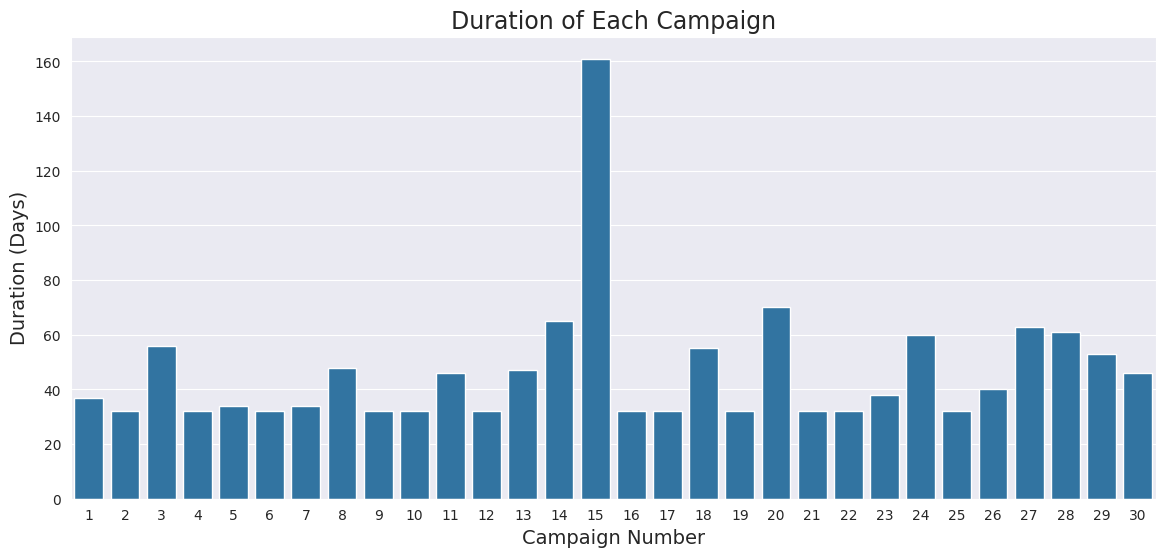

In [6]:
campaign_data = dfs["campaign_desc"]
campaign_data["campaign_duration"] = campaign_data["END_DAY"] - campaign_data["START_DAY"]

plt.figure(figsize=(14, 6))
sns.barplot(x="CAMPAIGN", y="campaign_duration", data=campaign_data, orient="v",
      order=campaign_data.sort_values(by="CAMPAIGN")["CAMPAIGN"].values)

plt.title('Duration of Each Campaign', fontsize=17)
plt.xlabel('Campaign Number', fontsize=14)
plt.ylabel('Duration (Days)', fontsize=14)
plt.show()

### Dataset  
Details of marketing campaigns per household.

In [7]:
dfs["campaign_table"] = pd.read_csv(data_folder+'campaign_table.csv')
dfs["campaign_table"].head()

,DESCRIPTION,household_key,CAMPAIGN
0,TypeA,17,26
1,TypeA,27,26
2,TypeA,212,26
3,TypeA,208,26
4,TypeA,192,26


Out of 2,500 household, 1,584 received a campaign, while the rest did not.

In [8]:
total_household = 2500
len(dfs["campaign_table"].household_key.unique())

1584

how many campaigns each household received

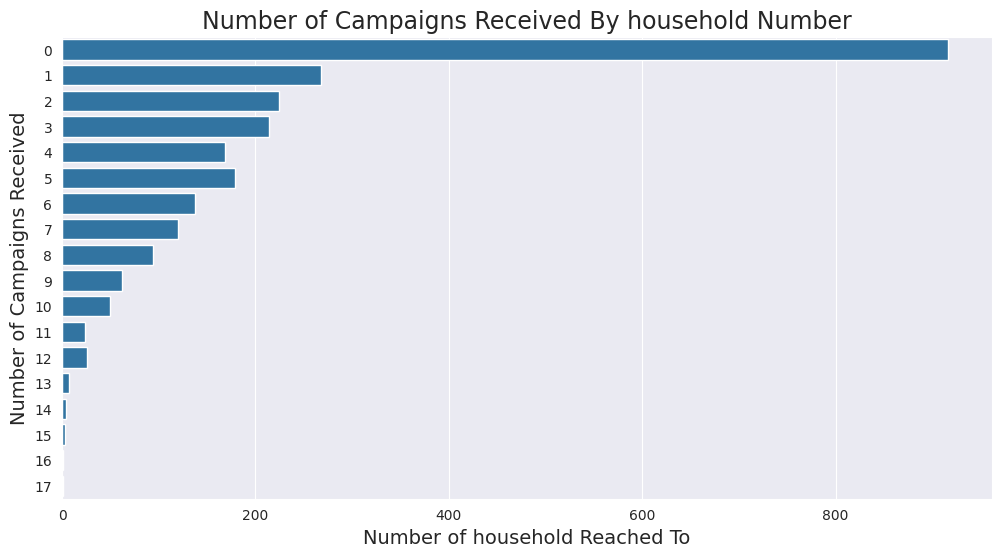

In [9]:
Campaign_received_per_house = dfs["campaign_table"].household_key.value_counts()
Campaign_received = Campaign_received_per_house.value_counts()
Campaign_received[0] = total_household-len(Campaign_received_per_house)
Campaign_received = pd.DataFrame(list(zip(Campaign_received.index,Campaign_received))
                      ,columns=["Number of Campaigns Received",
                          "Number of household Reached To"]).sort_values(
                                               by="Number of Campaigns Received",ascending=True)
plt.figure(figsize=(12,6))
sns.barplot(y="Number of Campaigns Received",x="Number of household Reached To",data=Campaign_received,orient="h",order=Campaign_received["Number of Campaigns Received"])
plt.title('Number of Campaigns Received By household Number', fontsize=17)
plt.xlabel('Number of household Reached To', fontsize=14)
plt.ylabel('Number of Campaigns Received', fontsize=14)
plt.show()

The graph shows Campaigns 18, 13, and 8 as the most frequent, each reaching over 1,000 unique household.

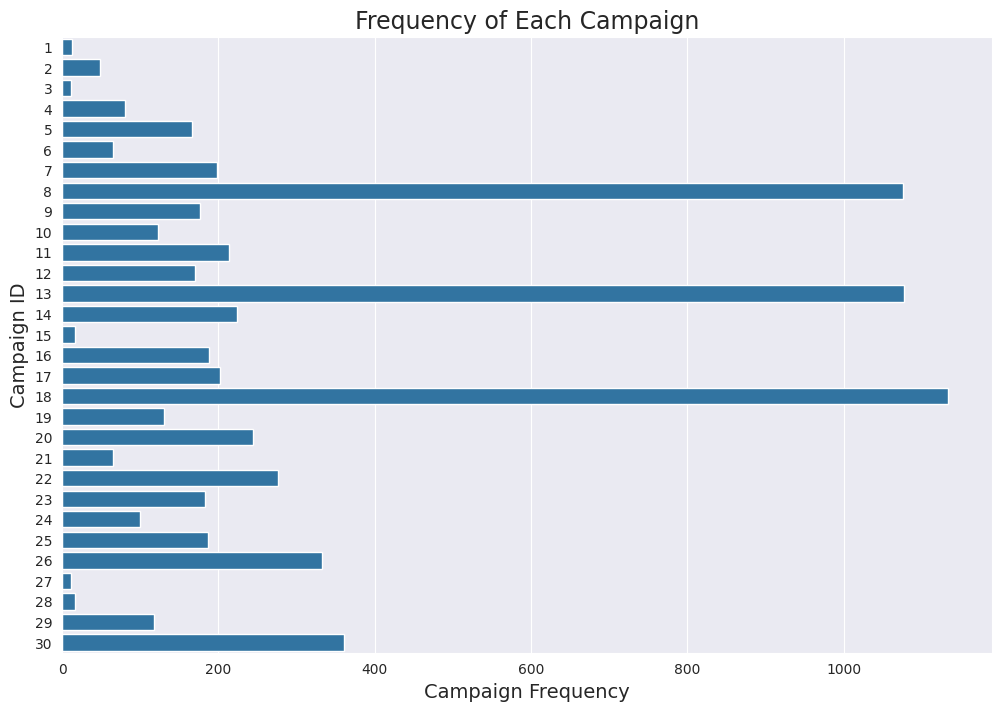

In [10]:
# Calculate the frequency of each campaign
campaign_counts = dfs["campaign_table"]["CAMPAIGN"].value_counts()

# Create a DataFrame for plotting
campaign_frequency_df = pd.DataFrame({
    "Campaign_ID": campaign_counts.index,
    "Campaign_Count": campaign_counts.values
})

# Create the bar plot
plt.figure(figsize=(12, 8))
sns.barplot(x="Campaign_Count", y="Campaign_ID", data=campaign_frequency_df, orient="h")
plt.title("Frequency of Each Campaign", fontsize=17)
plt.xlabel("Campaign Frequency", fontsize=14)
plt.ylabel("Campaign ID", fontsize=14)
plt.show()

In [11]:
transaction_data = pd.read_csv(data_folder + "transaction_data.csv")

### Coupons  
Lists coupons sent to customers and their redeemable products.

In [12]:
coupon_data = pd.read_csv(data_folder + "coupon.csv")
dfs["coupon"] = coupon_data
print(coupon_data.head())

    COUPON_UPC  PRODUCT_ID  CAMPAIGN
0  10000089061       27160         4
1  10000089064       27754         9
2  10000089073       28897        12
3  51800009050       28919        28
4  52100000076       28929        25


### Coupon Redemptions  
Details coupon redemptions by household, including coupon number, redemption day, and campaign number.

In [13]:
coupon_redempt_df = pd.read_csv(data_folder + "coupon_redempt.csv")
dfs["coupon_redempt"] = coupon_redempt_df
print(coupon_redempt_df.head())

   household_key  DAY   COUPON_UPC  CAMPAIGN
0              1  421  10000085364         8
1              1  421  51700010076         8
2              1  427  54200000033         8
3              1  597  10000085476        18
4              1  597  54200029176        18


Out of 2500 household, only 434 of them (17%) redeemed coupons within this period.

In [14]:
len(dfs["coupon_redempt"].household_key.unique())

434

### Redeems/Campaign  
Campaigns 18, 13, and 8 (Type A) lead in redemptions. The bar chart illustrates this.

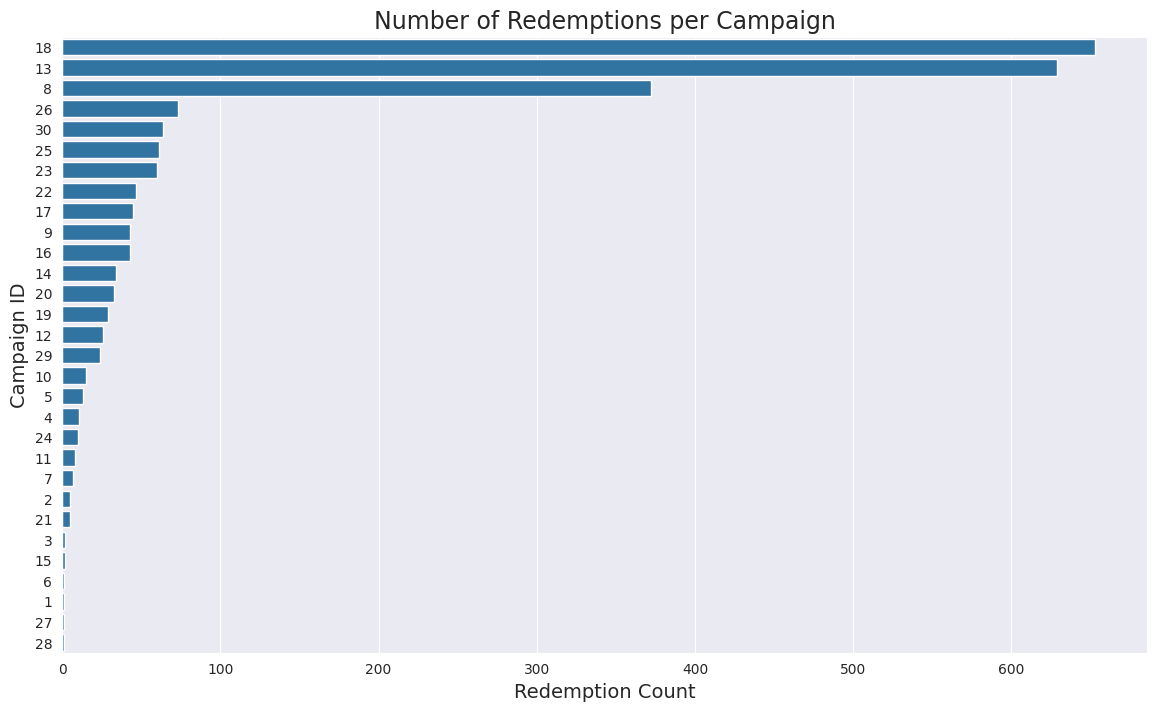

In [15]:
campaign_redemption_counts = pd.DataFrame(list(zip(dfs["coupon_redempt"].CAMPAIGN.value_counts().index, dfs["coupon_redempt"].CAMPAIGN.value_counts())),columns=["Campaign_ID","Redemption_Count"])
plot_figure = plt.figure(figsize=(14,8))
sns.barplot(y="Campaign_ID",x="Redemption_Count",data = campaign_redemption_counts,orient="h",order=campaign_redemption_counts.Campaign_ID)
plt.title('Number of Redemptions per Campaign', fontsize=17)
plt.xlabel('Redemption Count', fontsize=14)
plt.ylabel('Campaign ID', fontsize=14)
plt.show()

### Redeem Rates/Campaign  
The bar chart shows redeem rates in descending order, with Campaigns 13 and 18 leading at ~60%. Organizers effectively prioritized these campaigns.

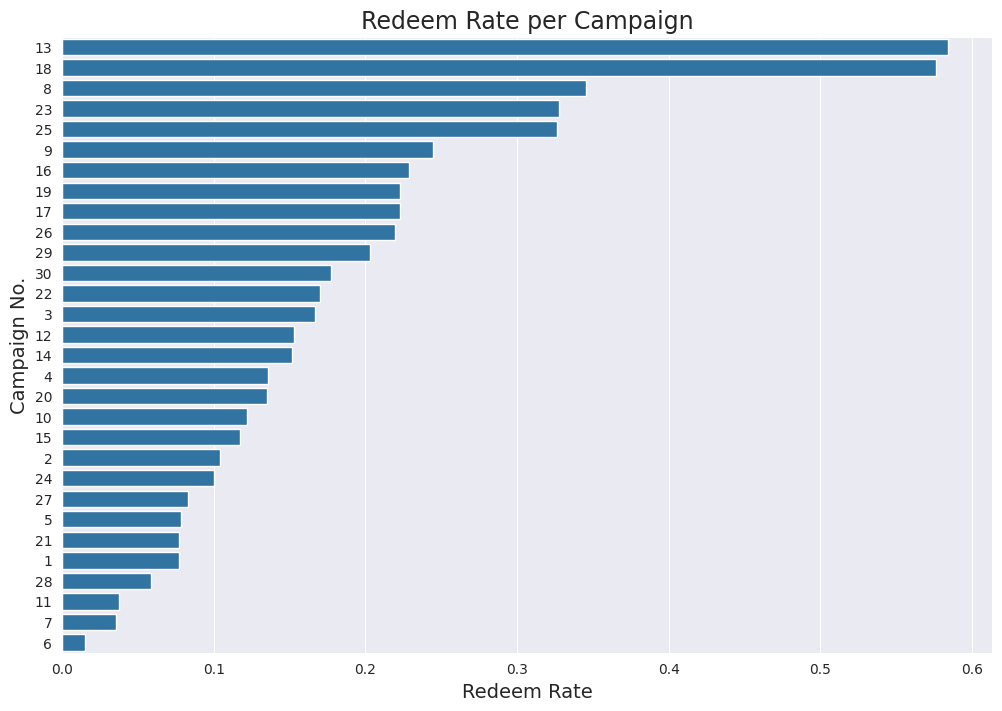

In [16]:
campaign_redeem_rates = dfs["coupon_redempt"].CAMPAIGN.value_counts().sort_values()/dfs["campaign_table"].CAMPAIGN.value_counts().sort_values()
campaign_redeem_rates_df = pd.DataFrame(list(zip(campaign_redeem_rates.index,campaign_redeem_rates)),
                columns=["Campaign_ID","Redemption_Rate"]).sort_values(by="Redemption_Rate",ascending=False)
plt.figure(figsize=(12,8))
sns.barplot(y="Campaign_ID",x="Redemption_Rate",data=campaign_redeem_rates_df,orient="h",order=campaign_redeem_rates_df.Campaign_ID)
plt.title('Redeem Rate per Campaign', fontsize=17)
plt.xlabel('Redeem Rate', fontsize=14)
plt.ylabel('Campaign No.', fontsize=14)
plt.show()

Transactional Data

Contains household purchase history, including product ID, sales value, store ID, and other details.


In [17]:
transaction_df = pd.read_csv(data_folder + "transaction_data.csv")
transaction_df.head()

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


In [18]:
dfs["transaction_data"] = pd.read_csv(data_folder+"transaction_data.csv")
dfs["transaction_data"].head()

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


#### Descriptive Analysis  
Grouping transactional data by household.

In [19]:
grouped_sum = dfs["transaction_data"].groupby("household_key").sum()

Average household Purchase (2 Years):

In [20]:
avg_purchase = round(dfs['transaction_data'].SALES_VALUE.sum()/len(grouped_sum),1)
avg_purchase

3223.0

#### Average Products Purchased per household (2 Years):  

In [21]:
avg_total_prod = round(grouped_sum["QUANTITY"].mean(),1)
avg_total_prod

104274.2

#### Average Unique Products Purchased per household (2 Years):  

In [22]:
avg_unique_prod = round(len(dfs["transaction_data"].groupby(["household_key","PRODUCT_ID"]).sum()["QUANTITY"])/len(grouped_sum),1)
avg_unique_prod

560.6

#### Average Store Visits per household (2 Years):  

In [23]:
avg_days_visited = round(len(dfs["transaction_data"].groupby(["household_key","DAY"]).count())/len(grouped_sum),1)
avg_days_visited

90.2

### Top Stores  
The top 20 stores by total sales (USD) are plotted below. Stores 367 and 406 lead among 582 stores, each exceeding $200,000 in sales.

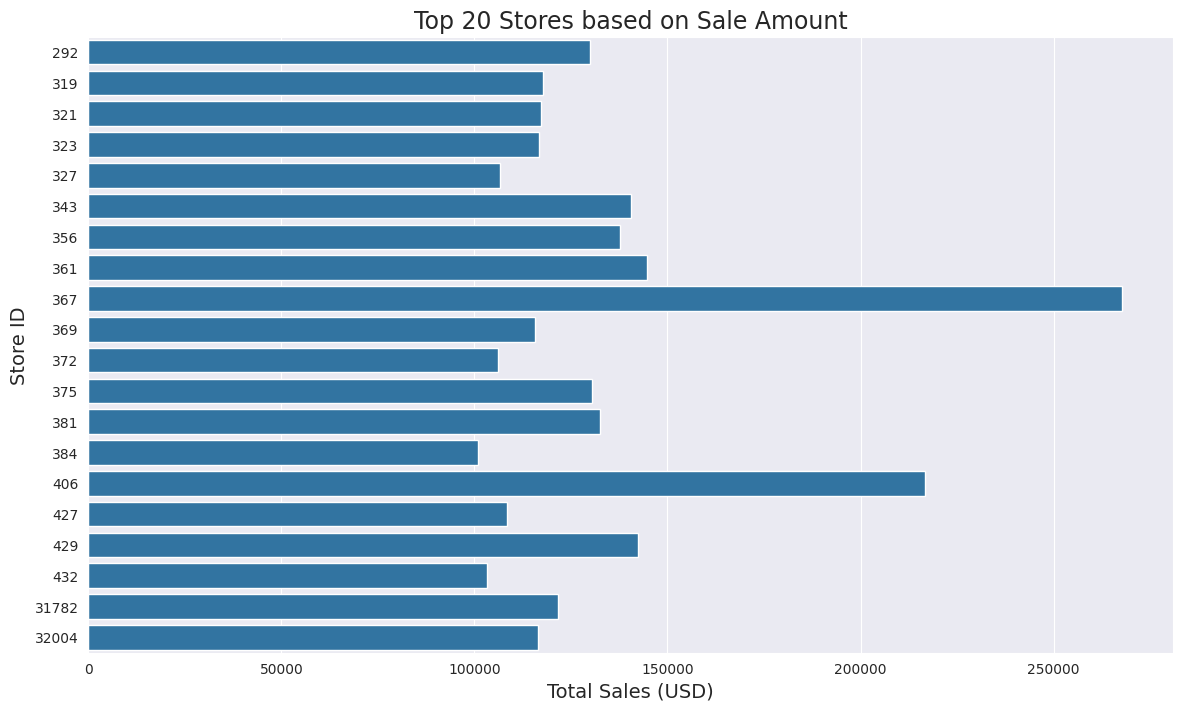

In [24]:
store_sales = dfs["transaction_data"].groupby("STORE_ID").sum()["SALES_VALUE"].sort_values(ascending=False)
store_sales_df = pd.DataFrame({"Store ID": store_sales.index, "Total Sales": store_sales.values})

fig_store=plt.figure(figsize=(14, 8))
sns.barplot(y="Store ID", x="Total Sales", data=store_sales_df.head(20), orient="h")

plt.title('Top 20 Stores based on Sale Amount', fontsize=17)
plt.xlabel('Total Sales (USD)', fontsize=14)
plt.ylabel('Store ID', fontsize=14)
plt.show()

Top 20 Customers

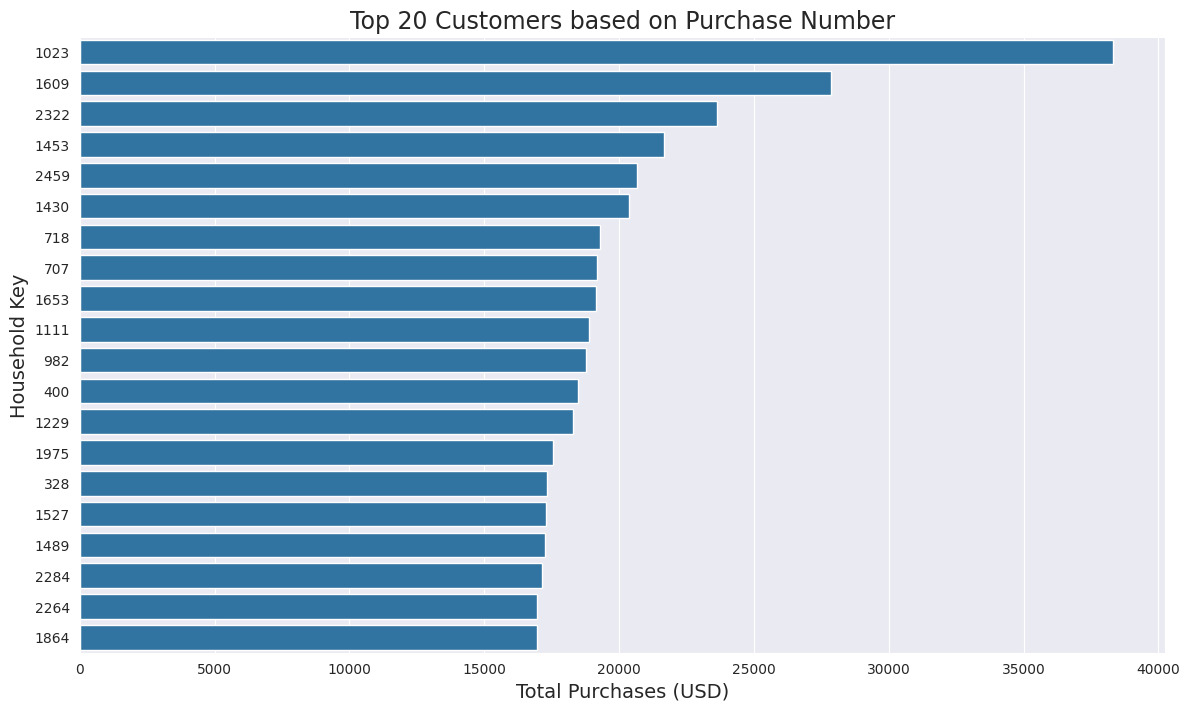

In [25]:
purc_per_cust = dfs["transaction_data"].groupby("household_key").sum()["SALES_VALUE"].sort_values(ascending=False)
purc_per_cust = pd.DataFrame(list(zip(purc_per_cust.index,purc_per_cust)),columns=["household_key","Total Purchase (USD)"])
fig_store = plt.figure(figsize=(14,8))
sns.barplot(y="household_key",x="Total Purchase (USD)",data = purc_per_cust[:20],order=purc_per_cust[:20]["household_key"],orient="h")
plt.title('Top 20 Customers based on Purchase Number', fontsize=17)
plt.xlabel('Total Purchases (USD)', fontsize=14)
plt.ylabel('Household Key', fontsize=14)
plt.show()

### Demographic

household details like age group, marital status, and size, forming the base table for feature engineering with churn target added pre-modeling.

In [26]:
dfs["hh_demographic"] = pd.read_csv(data_folder+"hh_demographic.csv")
dfs["hh_demographic"].head()

,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,household_key
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8
3,25-34,U,75-99K,Homeowner,2 Adults Kids,4,2,13
4,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown,16


Define the functions for exploratory analysis of demographic variables

In [27]:
def pie_category(data):
    #function to plot the histogram of categorical variables in pie graph
    features = data.columns
    #plot pie charts of categorical variables
    piechart_category = plt.figure(figsize=(15,15))
    count = 1
    #calculate dynamic numbers of subplot rows and columns
    cols = int(np.ceil(np.sqrt(len(features))))
    rows = int(np.ceil(len(features)/cols))
    for i in features:
     ax = piechart_category.add_subplot(rows,cols,count)
     data[i].value_counts().plot(kind="pie",autopct="%.1f%%",ax=ax)
     plt.ylabel("")
     plt.title(i,fontweight="bold",fontsize=8)
     count += 1

def hist_numeric(data):
    #function to plot the histogram of numeric variables
    features = data.columns
    fig_hists = plt.figure(figsize=(15,15))
    fig_hists.subplots_adjust(hspace=0.5,wspace=0.5)
    count = 1
    #calculate dynamic numbers of subplot rows and columns
    cols = int(np.ceil(np.sqrt(len(features))))
    rows = int(np.ceil(len(features)/cols))
    for i in features:
     ax = fig_hists.add_subplot(rows,cols,count)
     data[i].plot(kind="hist",alpha=.5,bins=25,edgecolor="navy",legend=False,ax=ax)
     ax.set_xlabel("")
     ax.set_title(i,fontweight="bold",fontsize=10)
     count += 1

All variables in the demographics dataset are categorical, so we used the _piecategorical function to generate pie charts showing their distributions.

Key insights:
~60% of customers are aged 35-54.
Married couples outnumber singles by nearly 3x.
50% earn $35-74K annually.
63% are homeowners.
70% do not have children.





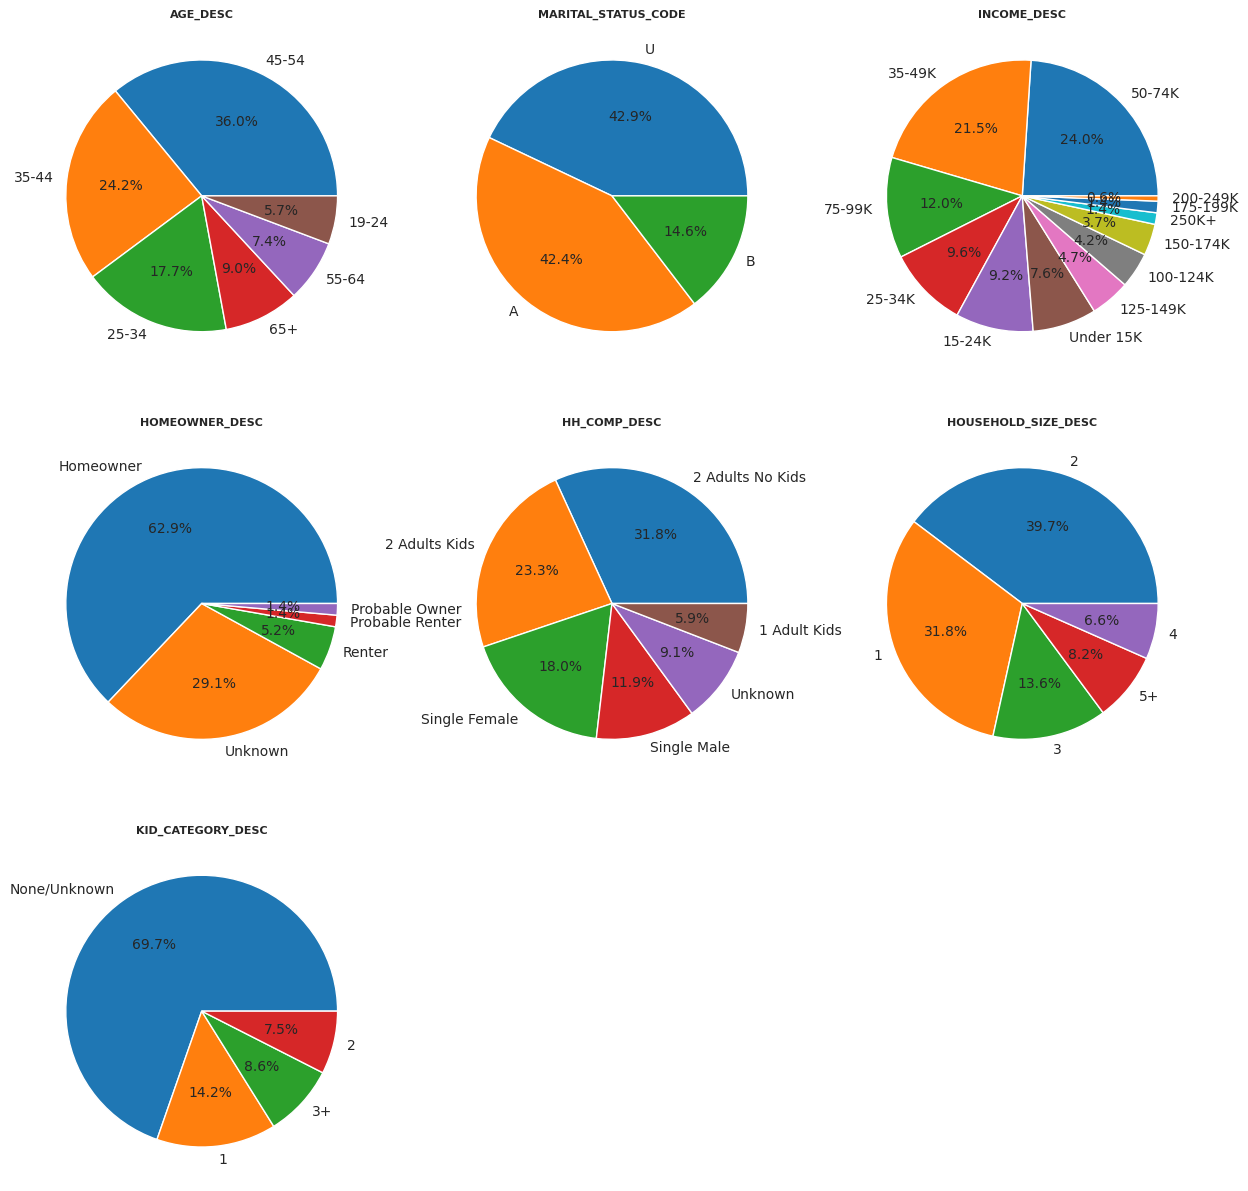

In [28]:
pie_category(dfs["hh_demographic"].drop("household_key",axis=1))



##Prediction
he dataset lacks a direct churn indicator, so we'll define our own churn criteria before modeling.

Key points:
Subscription-based churn: Easy to measure when payments are missed or canceled
Transactional churn: Harder to track since customers may be dormant, not churned.
Retail churn rates: Typically 5-7% per year; under 5% is excellent, while over 10% signals trouble.
Retention matters: Retaining customers is five times cheaper than acquiring new ones, and reducing churn by 5% can boost profits by up to 125%.

Our churn definition: A customer is considered churned if they haven’t made a purchase in 2 weeks or more. This threshold splits household into ~85% non-churned and ~15% churned.

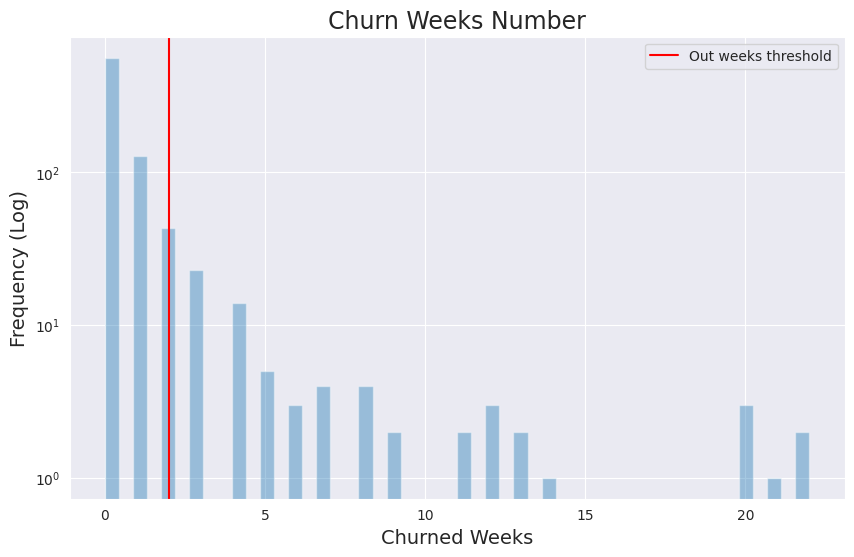

In [29]:
week_threshold = 2

#weekly customer purchase amount
weekly_buy = dfs["transaction_data"].groupby(["household_key","WEEK_NO"]).sum()["SALES_VALUE"]
weekly_buy = weekly_buy.unstack()

#customer churned by their last 2 week's purchasing behaviour
target = []
common_houses = set(dfs["hh_demographic"].household_key) & set(dfs["transaction_data"].household_key)
for house in common_houses:
  target.append(102-weekly_buy.loc[house].dropna().index[-1])

target = pd.DataFrame(list(zip(common_houses,target)),columns=["household_key","Churned weeks "])
plt.figure(figsize=(10,6))
ax = sns.distplot(target["Churned weeks "],kde=False)
ax.axvline(x=week_threshold,c="red",label="Out weeks threshold")
ax.legend()
ax.set_yscale("log")
ax.set_ylabel("Frequency (Log)", fontsize=14)
ax.set_xlabel("Churned Weeks", fontsize=14)

plt.title('Churn Weeks Number', fontsize=17)
# plt.xlabel('Total Purchases $', fontsize=14)
# plt.ylabel('household Key', fontsize=14)
plt.show()

Variable for modelling:

* Churned -> True
* Not Churned -> False

In [30]:
target["isChurned"] = target["Churned weeks "]>=week_threshold
target.drop("Churned weeks ",axis=1,inplace=True)

Let's see how household split with the defined churn:

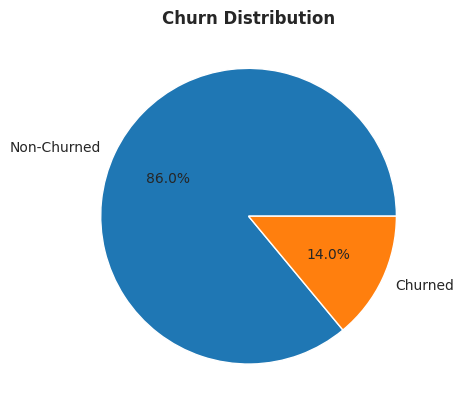

In [31]:
target.isChurned.value_counts().plot(kind="pie",autopct="%.1f%%",labels=["Non-Churned","Churned"])
plt.ylabel("")
plt.title("Churn Distribution",fontweight="bold")
plt.show()

### Feature Engineering

Feature 1: List of campaigns received by each household by grouping `household_key` and aggregating `campaign_id` from the Campaign Table.

In [32]:
household_by_camp = dfs["campaign_table"].groupby("CAMPAIGN")["household_key"].apply(list)
num_camp = len(dfs["campaign_table"].CAMPAIGN.unique())
df_camp = pd.DataFrame(np.full((total_household,num_camp),0),columns=["Camp_"+str(i) for i in range(1,num_camp+1)],
                                                        index=range(1,total_household+1))
for camp in household_by_camp.index:
    df_camp.loc[household_by_camp[camp],"Camp_"+str(camp)] = 1

df_camp["household_key"] = df_camp.index

**Feature 2**: Campaigns per household:

In [33]:
temp = dfs["campaign_table"].household_key.value_counts().sort_index()
Campaign_received = pd.DataFrame(list(zip(temp.index,temp.values.astype(int))),columns=["household_key","Campaign_received"])


The scatter plot below shows the correlation between the number of campaigns received by a household and their total purchase amount. The linear regression line indicates a clear linear relationship between these variables, suggesting that campaign frequency impacts household purchase behavior.

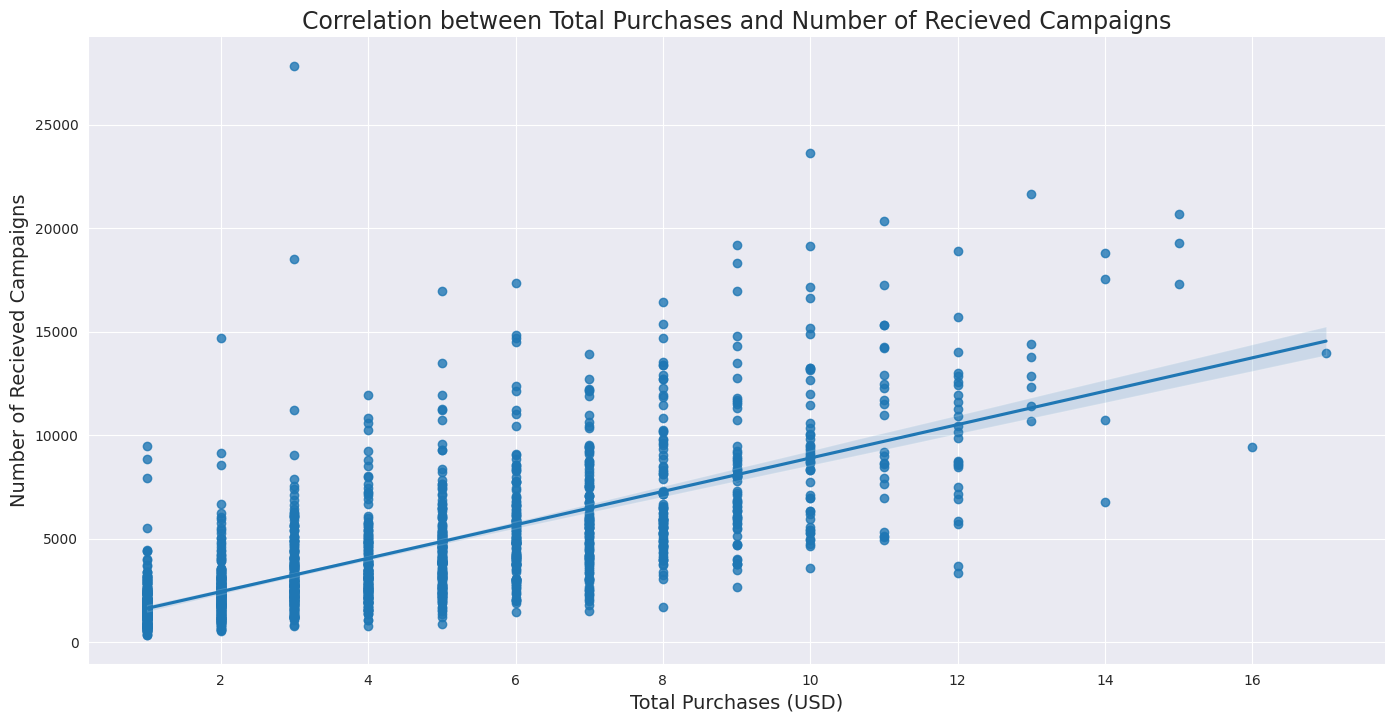

In [34]:
# plt.figure(figsize=(14,4))
campaigns_vs_purchases  = pd.merge(Campaign_received,purc_per_cust,on="household_key")
sns.lmplot(x="Campaign_received",y="Total Purchase (USD)",data=campaigns_vs_purchases ,
                                                       height=7, aspect=2)
plt.title('Correlation between Total Purchases and Number of Recieved Campaigns', fontsize=17)
plt.ylabel('Number of Recieved Campaigns', fontsize=14)
plt.xlabel('Total Purchases (USD)', fontsize=14)

plt.show()

In [35]:
campaigns_vs_purchases .drop("household_key",axis=1).corr()

,Campaign_received,Total Purchase (USD)
Campaign_received,1.000000,0.704409
Total Purchase (USD),0.704409,1.000000


The scatter plot and 71% correlation show a strong positive relationship between total purchases and campaigns received.



**Feature 3**: List of campaigns resulted in coupon redemption:

In [36]:
temp = dfs["coupon_redempt"].groupby("household_key")["CAMPAIGN"].apply(list)
history_coupon_household = pd.DataFrame(list(zip(temp.index,temp.values)),columns=["household_key","redeemed_CAMPAIGN_list"])

**Feature 4**: Redemptions made by each household:

In [37]:
temp = dfs["coupon_redempt"].household_key.value_counts().sort_index()
redeem_household = pd.DataFrame(list(zip(temp.index,temp.values.astype(int))),columns=["household_key","no_of_redeems"])

**Feature 5**: Frequent Campaign Type (A,B,C) each household:

In [38]:
camp_list = dfs["campaign_table"].groupby("household_key")["DESCRIPTION"].apply(list)
freq_camp = pd.DataFrame(list(zip(camp_list.index,[pd.Series(i).value_counts().idxmax() for i in camp_list])),columns=["household_key","most_freq_camp_type"])

**Feature 6**: Top 20 stores associated with the highest churn rates to analyze and address potential churn factors.

In [39]:
# Get unique stores per household
stores_per_household = dfs["transaction_data"].groupby("household_key")["STORE_ID"].apply(lambda x: np.unique(x).tolist())

# Identify churned household and their associated stores
churned_household = set(target.household_key[target.isChurned].values) & set(dfs["hh_demographic"].household_key)
churned_stores = [store for household in churned_household for store in stores_per_household[household]]

# Calculate churn store distribution
churn_store_distribution = pd.Series(churned_stores).value_counts() / len(churned_household)

# Create a store-household matrix for transaction data
store_household_matrix = dfs["transaction_data"].groupby(["STORE_ID", "household_key"])["BASKET_ID"].count().unstack(fill_value=0)
store_household_matrix = (store_household_matrix > 0).astype(int)

# Select top stores with the highest number of churners
top_churn_stores = churn_store_distribution.index[:20]
# Change is here: Select rows based on top_churn_stores and then transpose to get stores as columns
store_household_matrix = store_household_matrix.loc[top_churn_stores].T
store_household_matrix.columns = [f"Store_{store_id}" for store_id in store_household_matrix.columns]

Feature 7: Amount of purchase of a household within two years:

In [40]:
purchase_by_customer = dfs["transaction_data"].groupby("household_key").sum()["SALES_VALUE"].sort_values(ascending=False)
purchase_by_customer = pd.DataFrame(list(zip(purchase_by_customer.index,purchase_by_customer)),columns=["household_key","Total Purchase (USD)"])

### Last touches on the dataset
Generate the final dataframe to be used for predictive modelling

In [41]:
data = pd.merge(dfs["hh_demographic"],df_camp,on="household_key",how="left")
data = pd.merge(data,Campaign_received,on="household_key",how="left")
data = pd.merge(data,store_household_matrix,on="household_key",how="left")
data = pd.merge(data,redeem_household,on="household_key",how="left")
data = pd.merge(data,freq_camp,on="household_key",how="left")
data = pd.merge(data,purchase_by_customer,on="household_key",how="left")
data = pd.merge(data,target,on="household_key",how="left")

In [42]:
data.shape

(801, 63)

Now we have 91 features and a target variable in the final dataframe

In [43]:
data.head()

,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,household_key,Camp_1,Camp_2,...,Store_321,Store_433,Store_319,Store_320,Store_375,Store_292,no_of_redeems,most_freq_camp_type,Total Purchase (USD),isChurned
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1,0,0,...,0,0,0,0,0,0,5.0,TypeB,4330.16,False
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7,0,0,...,0,0,0,0,0,0,NaN,TypeB,3400.05,False
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8,0,0,...,1,0,0,0,0,0,1.0,TypeB,5534.97,False
3,25-34,U,75-99K,Homeowner,2 Adults Kids,4,2,13,0,0,...,0,0,0,0,0,0,21.0,TypeB,13190.92,False
4,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown,16,0,1,...,0,0,0,0,0,0,NaN,TypeA,1512.02,True


Change NaN or None/Unknown values to zero for the columns of "number of received campaigns", "kid category" and the "number of redeems"

In [44]:
data.Campaign_received.replace(np.nan,0,inplace=True)
data.Campaign_received = data.Campaign_received.astype(int)
data.no_of_redeems.replace(np.nan,0,inplace=True)

Change other object type elements in the columns to integer for modeling purpose

In [45]:
data.KID_CATEGORY_DESC.replace(["None/Unknown","3+"],[0,3],inplace=True)
data.KID_CATEGORY_DESC = data.KID_CATEGORY_DESC.astype(int)
data.HOUSEHOLD_SIZE_DESC.replace("5+",5,inplace=True)
data.HOUSEHOLD_SIZE_DESC_DESC = data.HOUSEHOLD_SIZE_DESC.astype(int)
data["Total Purchase (USD)"] = data["Total Purchase (USD)"].astype(int)

In [46]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Data columns (total 63 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   AGE_DESC              801 non-null    object 
 1   MARITAL_STATUS_CODE   801 non-null    object 
 2   INCOME_DESC           801 non-null    object 
 3   HOMEOWNER_DESC        801 non-null    object 
 4   HH_COMP_DESC          801 non-null    object 
 5   HOUSEHOLD_SIZE_DESC   801 non-null    object 
 6   KID_CATEGORY_DESC     801 non-null    int64  
 7   household_key         801 non-null    int64  
 8   Camp_1                801 non-null    int64  
 9   Camp_2                801 non-null    int64  
 10  Camp_3                801 non-null    int64  
 11  Camp_4                801 non-null    int64  
 12  Camp_5                801 non-null    int64  
 13  Camp_6                801 non-null    int64  
 14  Camp_7                801 non-null    int64  
 15  Camp_8                8

The household_key is a household ID and will be excluded from modeling; all other data will be used.

In [47]:
data.dtypes.value_counts()

,count
int64,54
object,7
float64,1
bool,1


**Households aged 55-64 churn less, with no clear age-related trend in churn rates.**

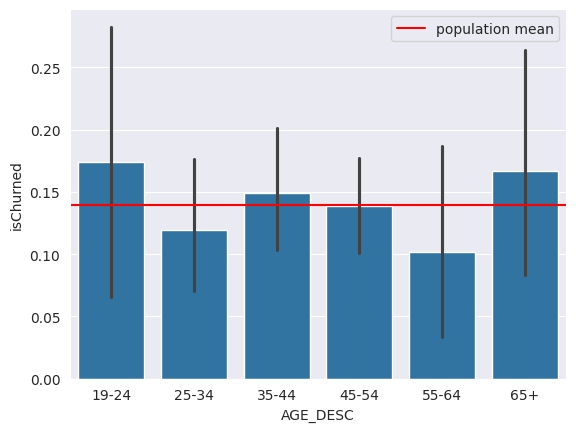

In [48]:
ax = sns.barplot(x="AGE_DESC",y="isChurned",data=data,order=["19-24","25-34","35-44","45-54","55-64","65+"])
ax.axhline(y=data.isChurned.sum()/len(data),c="red",label="population mean")
ax.legend()
plt.show()

**Married couples churn more, and unknown marital status increases overall churn rates.**


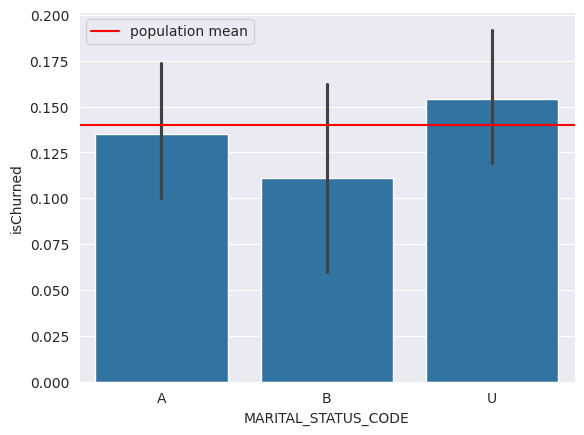

In [49]:
ax = sns.barplot(x="MARITAL_STATUS_CODE",y="isChurned",data=data,order=["A","B","U"])
ax.axhline(y=data.isChurned.sum()/len(data),c="red",label="population mean")
ax.legend()
plt.show()

Income vs. Churn:  
- No clear trend across income groups.  
- Households earning $175K+ show no churn (27 out of 801 samples).

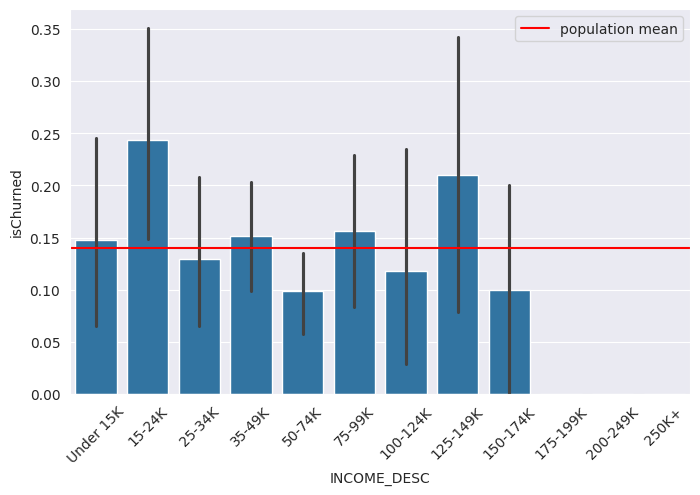

In [50]:
fig = plt.figure(figsize=(8,5))
ax = sns.barplot(x="INCOME_DESC",y="isChurned",data=data,
           order=["Under 15K","15-24K","25-34K","35-49K","50-74K","75-99K","100-124K","125-149K","150-174K","175-199K","200-249K","250K+"])
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
ax.axhline(y=data.isChurned.sum()/len(data),c="red",label="population mean")
ax.legend()
plt.show()

Home Ownership vs Churn Rate:

No differences between owners and renters

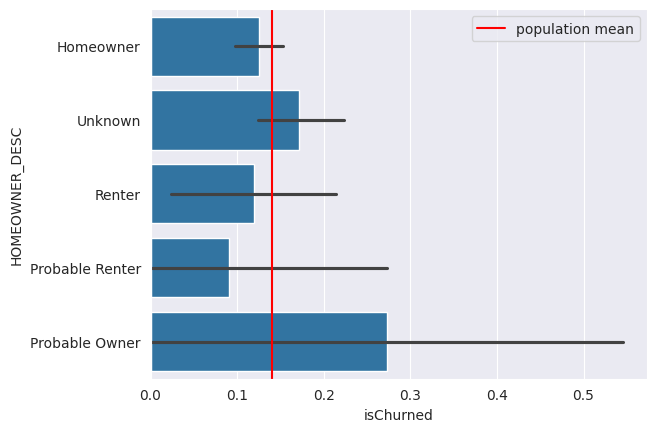

In [51]:
ax = sns.barplot(y="HOMEOWNER_DESC",x="isChurned",data=data,orient="h")
ax.axvline(x=data.isChurned.sum()/len(data),c="red",label="population mean")
ax.legend()
plt.show()

**Number of Redeems vs. Churn Rate**:  
- Grouped households by redeems (0, 1, and more than 1).  
- Churn rate decreases as redeems increase.

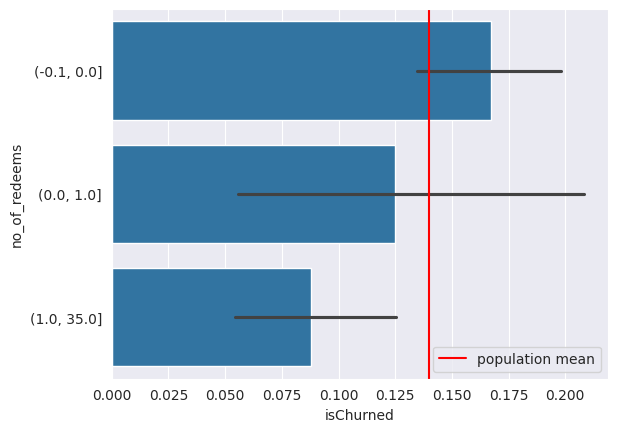

In [52]:
ax = sns.barplot(y=pd.cut(data.no_of_redeems,bins=[-0.1,0,1,35],duplicates="drop"),x="isChurned",data=data,orient="h")
ax.axvline(x=data.isChurned.sum()/len(data),c="red",label="population mean")
ax.legend()
plt.show()

Churn rate vs Number of campaigns received by a household

* Churn rate decreases as the number of campaigns received by a household increases

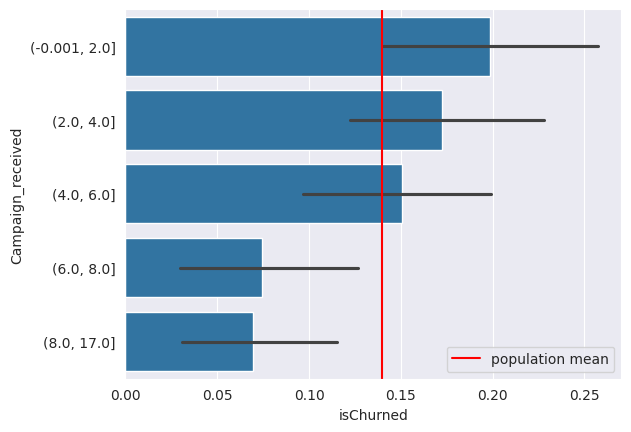

In [53]:
ax = sns.barplot(y=pd.qcut(data.Campaign_received,5,duplicates="drop"),x="isChurned",data=data,orient="h")
ax.axvline(x=data.isChurned.sum()/len(data),c="red",label="population mean")
ax.legend()
plt.show()

**The barplot indicates reduction of churn in household with 2 adults and kid.**

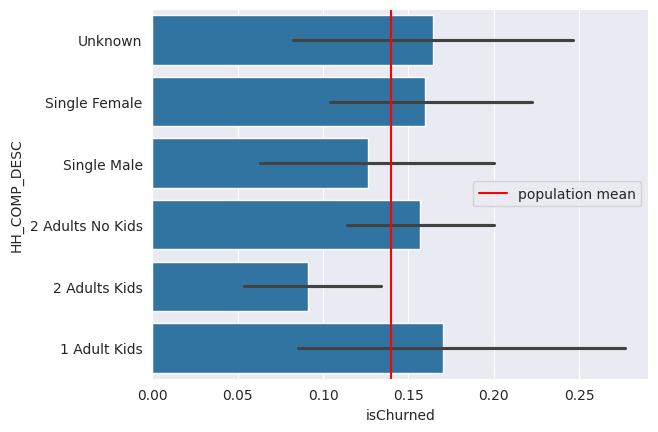

In [54]:
ax = sns.barplot(y="HH_COMP_DESC",x="isChurned",data=data,orient="h",order=['Unknown','Single Female','Single Male','2 Adults No Kids','2 Adults Kids','1 Adult Kids'])
ax.axvline(x=data.isChurned.sum()/len(data),c="red",label="population mean")
ax.legend()
plt.show()

Churn rate tends to decrease as the number of family members increases

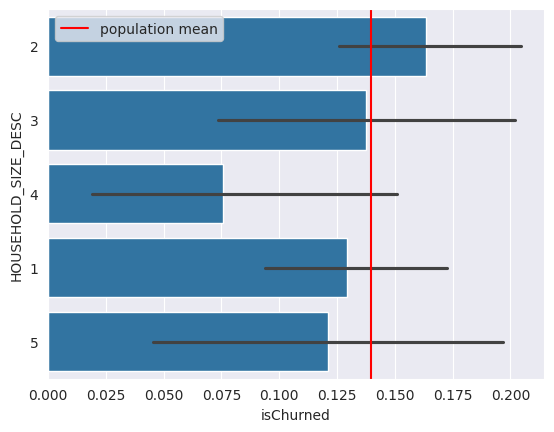

In [55]:
ax = sns.barplot(y="HOUSEHOLD_SIZE_DESC",x="isChurned",data=data,orient="h")
ax.axvline(x=data.isChurned.sum()/len(data),c="red",label="population mean")
ax.legend()
plt.show()

**Campaign Type vs. Churn**:  
- Type C shows 100% churn but has a very small sample size (1%).  
- Type B is the most effective with the lowest churn rate.

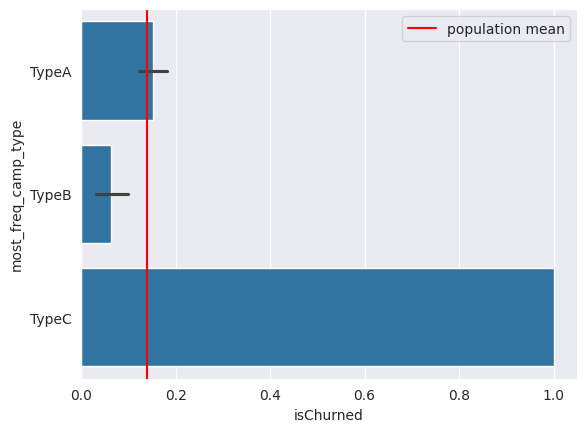

In [56]:
ax = sns.barplot(y="most_freq_camp_type",x="isChurned",data=data,orient="h",order=['TypeA','TypeB','TypeC'])
ax.axvline(x=data.isChurned.sum()/len(data),c="red",label="population mean")
ax.legend()
plt.show()

**Total Purchases vs. Churn**:  
- Total purchase amount effectively separates churners and is a strong predictor.  
- Churn rate decreases as household purchases (over 2 years) increase.

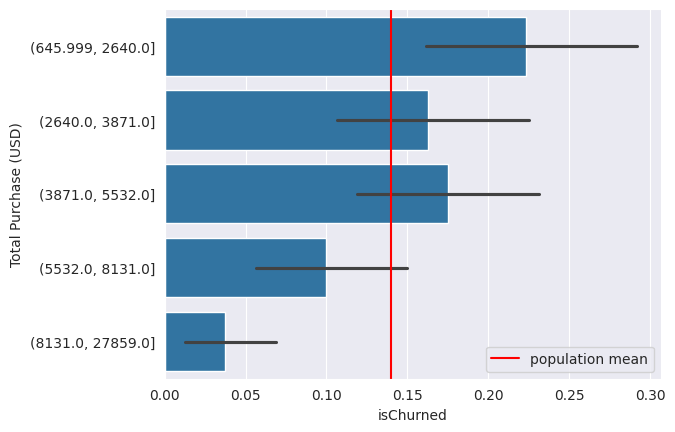

In [57]:
ax = sns.barplot(y=pd.qcut(data["Total Purchase (USD)"],5,duplicates="drop"),x="isChurned",data=data,orient="h")
ax.axvline(x=data.isChurned.sum()/len(data),c="red",label="population mean")
ax.legend()
plt.show()

# **Campaign Number vs. Churn**:  
- Campaign 25 shows the highest correlation with churn and is expected to perform well as a feature.


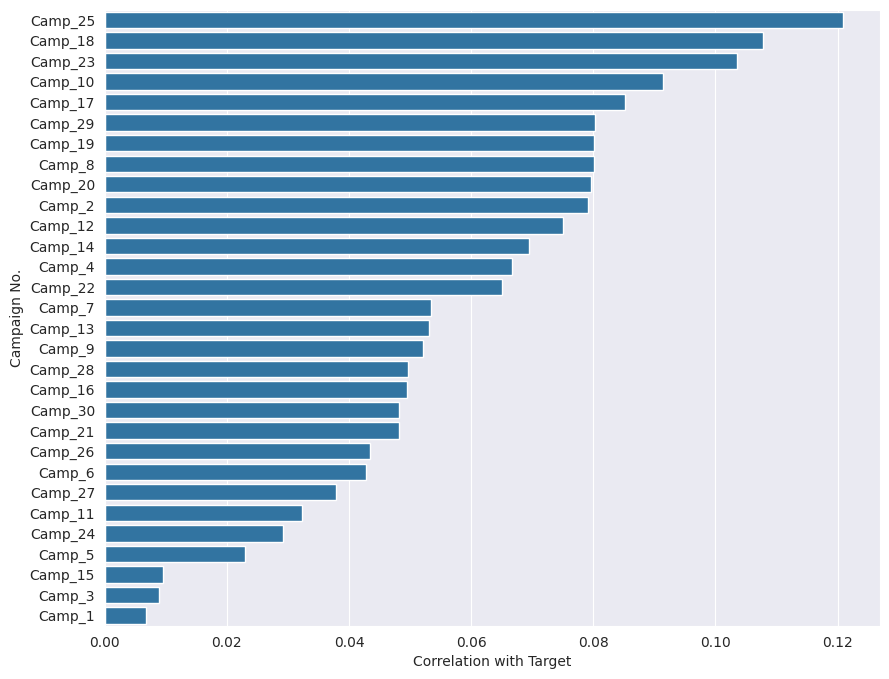

In [58]:
corrs = abs(data[["Camp_"+str(i) if i<31 else "isChurned" for i in range(1,32)]].corr()["isChurned"])
corrs.drop("isChurned",inplace=True)
corrs = pd.DataFrame(list(zip(corrs.index,corrs)),columns=["Campaign No.","Correlation with Target"]).sort_values(by="Correlation with Target",ascending=False)
fig_store = plt.figure(figsize=(10,8))
sns.barplot(y="Campaign No.",x="Correlation with Target",data = corrs,orient="h")
plt.show()

Correlation between stores with high churn and the target (isChurned) is shown in the bar chart.

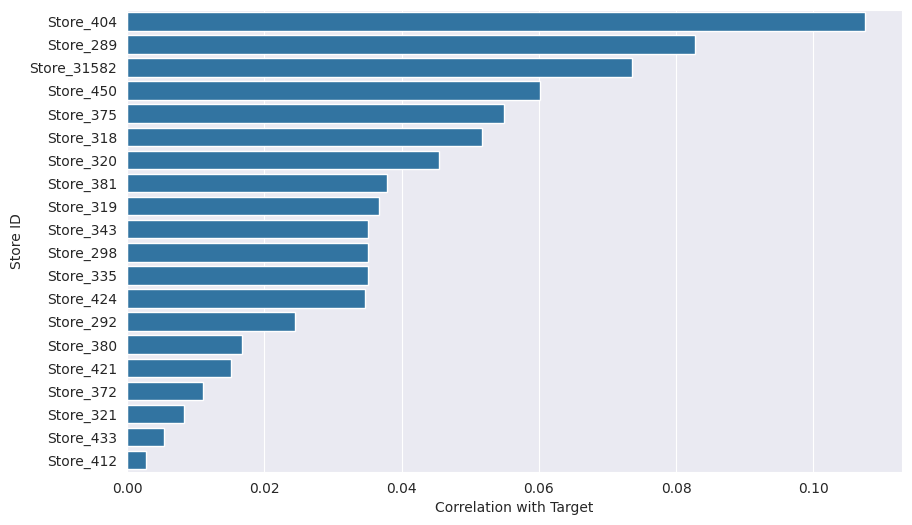

In [59]:
cols =list(store_household_matrix.columns)
cols.extend(["isChurned"])
corrs = abs(data[cols].corr()["isChurned"])
corrs.drop("isChurned",inplace=True)
corrs = pd.DataFrame(list(zip(corrs.index,corrs)),columns=["Store ID","Correlation with Target"]).sort_values(by="Correlation with Target",ascending=False)
fig_store = plt.figure(figsize=(10,6))
sns.barplot(y="Store ID",x="Correlation with Target",data = corrs,orient="h")
plt.show()

### ML Model Training & Testing
In this section we will train a Machine Learning model .

We one-hot encoded categorical variables, split the data (75% train, 25% test)

Now, let’s test it on the test set:

In [60]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
encoded = pd.get_dummies(data[data.columns[data.dtypes==object]])
data_encoded = pd.concat([encoded, data[data.columns[data.dtypes != object]]],axis=1)

#Features (X) and the target (y)
X = data_encoded.drop("isChurned",axis=1)
y = data_encoded.isChurned

#lets start with the default hyperparameters and hold-out mechanism for train/test split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25)

#XGBoost
xgb_mdl = xgb.XGBClassifier().fit(X_train.values,y_train.values)
xgb_mdl

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

=== Training Data Classification Report ===
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       515
        True       1.00      1.00      1.00        85

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600


=== Test Data Classification Report ===
              precision    recall  f1-score   support

       False       0.87      0.94      0.90       174
        True       0.21      0.11      0.15        27

    accuracy                           0.83       201
   macro avg       0.54      0.52      0.52       201
weighted avg       0.78      0.83      0.80       201



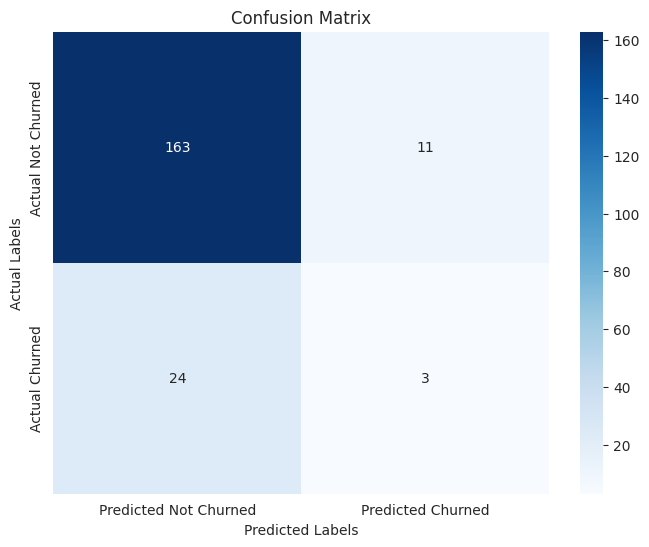

ROC AUC Score: 0.65
Accuracy: 0.83


In [61]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt


# Evaluate on Training and Test Data
y_train_pred = xgb_mdl.predict(X_train.values)
y_test_pred = xgb_mdl.predict(X_test.values)

# Classification Report
print("=== Training Data Classification Report ===")
print(classification_report(y_train, y_train_pred))

print("\n=== Test Data Classification Report ===")
print(classification_report(y_test, y_test_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
conf_matrix_df = pd.DataFrame(
    conf_matrix,
    index=["Actual Not Churned", "Actual Churned"],
    columns=["Predicted Not Churned", "Predicted Churned"]
)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_df, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("Actual Labels")
plt.show()

# ROC AUC Score
y_test_proba = xgb_mdl.predict_proba(X_test.values)[:, 1]  # Probability for the positive class
roc_auc = roc_auc_score(y_test, y_test_proba)
print(f"ROC AUC Score: {roc_auc:.2f}")

# Accuracy Score
accuracy = accuracy_score(y_test, y_test_pred)
print(f"Accuracy: {accuracy:.2f}")

=== Training Data Classification Report ===
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       515
        True       1.00      1.00      1.00        85

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600


=== Test Data Classification Report ===
              precision    recall  f1-score   support

       False       0.87      0.94      0.90       174
        True       0.21      0.11      0.15        27

    accuracy                           0.83       201
   macro avg       0.54      0.52      0.52       201
weighted avg       0.78      0.83      0.80       201



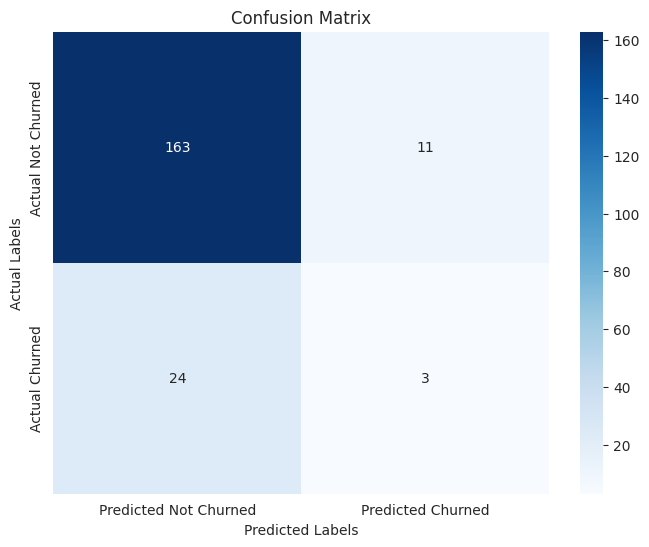

ROC AUC Score: 0.65
Accuracy: 0.83


In [62]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
# Evaluate on Training and Test Data
y_train_pred = xgb_mdl.predict(X_train.values)
y_test_pred = xgb_mdl.predict(X_test.values)

# Classification Report
print("=== Training Data Classification Report ===")
print(classification_report(y_train, y_train_pred))

print("\n=== Test Data Classification Report ===")
print(classification_report(y_test, y_test_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
conf_matrix_df = pd.DataFrame(
    conf_matrix,
    index=["Actual Not Churned", "Actual Churned"],
    columns=["Predicted Not Churned", "Predicted Churned"]
)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_df, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("Actual Labels")
plt.show()

# ROC AUC Score
y_test_proba = xgb_mdl.predict_proba(X_test.values)[:, 1]  # Probability for the positive class
roc_auc = roc_auc_score(y_test, y_test_proba)
print(f"ROC AUC Score: {roc_auc:.2f}")

# Accuracy Score
accuracy = accuracy_score(y_test, y_test_pred)
print(f"Accuracy: {accuracy:.2f}")


# Association Rules

In [63]:
import pandas as pd
from scipy.sparse import coo_matrix
from mlxtend.frequent_patterns import apriori, association_rules
import xgboost as xgb
from sklearn.model_selection import train_test_split

transactions = pd.read_csv(data_folder+'transaction_data.csv')
products = pd.read_csv(data_folder+'product.csv')

df = pd.merge(transactions, products, on='PRODUCT_ID', how='inner')

print(df.head())
# Map baskets and products to indices
basket_map = {basket_id: i for i, basket_id in enumerate(df['BASKET_ID'].unique())}
product_map = {product_id: i for i, product_id in enumerate(df['DEPARTMENT'].unique())}

row = df['BASKET_ID'].map(basket_map)
col = df['DEPARTMENT'].map(product_map)
data = [1] * len(row)

# Construct sparse matrix
sparse_matrix = coo_matrix((data, (row, col)), shape=(len(basket_map), len(product_map)))

# Convert sparse matrix to a DataFrame
basket_product_df = pd.DataFrame.sparse.from_spmatrix(sparse_matrix,
                                                      index=basket_map.keys(),
                                                      columns=product_map.keys())

basket_product_df.columns = [str(i) for i in basket_product_df.columns]

print(basket_product_df.head())

basket_product_df = basket_product_df.applymap(lambda x: 1 if x > 0 else 0)

# Apply Apriori Algorithm
frequent_itemsets = apriori(basket_product_df, min_support=0.5, use_colnames=True)

# Generate Association Rules
rules = association_rules(frequent_itemsets,num_itemsets=len(basket_product_df),metric="lift", min_threshold=0.2)

# Display results
print("Frequent Itemsets:")
print(frequent_itemsets)

print("\nAssociation Rules:")
print(rules)

   household_key    BASKET_ID  DAY  PRODUCT_ID  QUANTITY  SALES_VALUE  \
0           2375  26984851472    1     1004906         1         1.39   
1           2375  26984851472    1     1033142         1         0.82   
2           2375  26984851472    1     1036325         1         0.99   
3           2375  26984851472    1     1082185         1         1.21   
4           2375  26984851472    1     8160430         1         1.50   

   STORE_ID  RETAIL_DISC  TRANS_TIME  WEEK_NO  COUPON_DISC  COUPON_MATCH_DISC  \
0       364        -0.60        1631        1          0.0                0.0   
1       364         0.00        1631        1          0.0                0.0   
2       364        -0.30        1631        1          0.0                0.0   
3       364         0.00        1631        1          0.0                0.0   
4       364        -0.39        1631        1          0.0                0.0   

   MANUFACTURER DEPARTMENT     BRAND               COMMODITY_DESC  \
0    

/usr/local/lib/python3.10/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


# RFM

In [64]:
#import pandas as pd

# Load transaction data
#transactions = pd.read_csv(data_folder + 'transaction_data.csv')

# Filter transactions with positive sales value
valid_transactions = transactions[transactions['SALES_VALUE'] > 0]

# Aggregate data to create the customer datamart
customer_datamart = valid_transactions.groupby('household_key').agg({
    'DAY': lambda days: 712 - days.max(),  # Recency calculation
    'BASKET_ID': 'nunique',                # Frequency calculation
    'SALES_VALUE': 'sum'                   # Monetary calculation
}).rename(columns={
    'DAY': 'Recency(Days)',
    'BASKET_ID': 'TransactionFrequency',
    'SALES_VALUE': 'TotalMonetaryValue'
})

# Assign Recency quartiles
customer_datamart['RecencyScore'] = pd.qcut(customer_datamart['Recency(Days)'], 4, labels=range(4, 0, -1))

# Display the final customer datamart
print(customer_datamart)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


               Recency(Days)  TransactionFrequency  TotalMonetaryValue  \
household_key                                                            
1                          6                    85             4330.16   
2                         44                    45             1954.34   
3                          9                    47             2653.21   
4                         85                    30             1200.11   
5                          9                    40              779.06   
...                      ...                   ...                 ...   
2496                      29                    63             4339.66   
2497                      12                   221             7111.98   
2498                       2                   172             2601.60   
2499                       3                    90             3394.07   
2500                       4                   113             5486.16   

              RecencyScore  
househol